Here we compare 4 testing schemes: Dubey & Muller, Energy statistic (Szekely & Rizzo 2004), HIPM, WoW.

In particular we compare power functions on the example of random probability measures from Fig 1 Dubey & Muller.

In [1]:
using Plots
using KernelDensity


include("distributions.jl")

include("distances/new_distance.jl")
include("distances/distance_Wasserstein.jl")


ww (generic function with 2 methods)

In [2]:
function test_statistic_dm(pms_1::Vector{Normal}, pms_2::Vector{Normal})
    # given two samples of probobability measures, compute the test statistic according to Dubey & Muller
    n = length(pms_1)
    # Recall that we assume that each of the sample is Normal distribution, and for W_2 metric we only need their means.
    X = [pms_1[i].μ for i in 1:n] # collect all the means from first samples of probability measures
    Y = [pms_2[i].μ for i in 1:n] # collect all the means from second samples of probability measures
    
    μ_hat_1 = mean(X)
    μ_hat_2 = mean(Y)

    v_hat_1 = mean((X .- μ_hat_1).^2)
    v_hat_2 = mean((Y .- μ_hat_2).^2)

    σ_hat_1_squared = mean((X .- μ_hat_1).^4) - (v_hat_1)^2
    σ_hat_2_squared = mean((Y .- μ_hat_2).^4) - (v_hat_2)^2
    
    μ_hat_p = sum(X .+ Y) / (2 * n)
    v_hat_p = sum( (X .- μ_hat_p).^2 .+ (Y .- μ_hat_p).^2 ) / (2 * n)

    F_n = v_hat_p - v_hat_1/2 - v_hat_2/2
    U_n = (1/4) * ((v_hat_1 - v_hat_2)^2) / (σ_hat_1_squared * σ_hat_2_squared) 
    
    T_n = 2*n*U_n / (1/(2*σ_hat_1_squared) + 1/(2*σ_hat_2_squared) ) + 2 * n * (F_n^2) / (σ_hat_1_squared/4 + σ_hat_2_squared/4)

    return T_n
end




test_statistic_dm (generic function with 1 method)

In [3]:
function test_statistic_energy(pms_1::Vector{Normal}, pms_2::Vector{Normal})
    # Recall that we assume that each of the sample is Normal distribution, and for W_2 metric we only need their means.
    n = length(pms_1)
    @assert n == length(pms_2) "two samples of probability measures must have same size "

    X = [pms_1[i].μ for i in 1:n] # collect all the means from first samples of probability measures
    Y = [pms_2[i].μ for i in 1:n] # collect all the means from second samples of probability measures

    distances_X = [abs(X[i] - X[j]) for i in 1:n, j in 1:n]
    distances_Y = [abs(Y[i] - Y[j]) for i in 1:n, j in 1:n]
    distances_XY = [abs(X[i] - Y[j]) for i in 1:n, j in 1:n]


    distance = 2 * mean(distances_XY) - mean(distances_X) - mean(distances_Y)
    T_n = distance * n / 2
    return T_n
end



function decide_energy_boostrap(pms_1::Vector{Normal}, pms_2::Vector{Normal}, n_boostrap::Int, θ = 0.05)
    # given two samples of probobability measures, this function returns 0 or 1, i.e. either rejects or accepts 
    # null hypothesis for given significance level θ according to Energy statistic (Szekely & Rizzo 2004).

    # n_boostrap: number of times we repeat bootstrap procedure to estimate the quantile of the test statistic

    n_top = length(pms_1)
    T_n = test_statistic_energy(pms_1, pms_2) # test statistic
    # obtain quantile using bootstrap approach
    T_n_boostrap = zeros(n_boostrap)
    for s in 1:n_boostrap
        allmeasures = vcat(pms_1, pms_2) # collect all probability measures into one vector
        pms_1_boostrap = sample(allmeasures, n_top; replace=true) # resample from pooled probability measures
        pms_2_boostrap = sample(allmeasures, n_top; replace=true) # resample from pooled probability measures
        T_n_boostrap[s] = test_statistic_energy(pms_1_boostrap, pms_2_boostrap) # test statistic from boostraped sample
    end
    threshold = quantile(T_n_boostrap, 1-θ)
    decision = 1.0*(T_n > threshold) # 1.0 if T_n > threshold, 0.0 otherwise.
    return decision
end

decide_energy_boostrap (generic function with 2 methods)

In [4]:
function decide_dm_asympt(pms_1::Vector{Normal}, pms_2::Vector{Normal}, n_boostrap::Int, θ = 0.05)
    # given two samples of probobability measures, this function returns 0 or 1, i.e. either rejects or accepts 
    # null hypothesis for given significance level θ according to Dubey & Muller.

    # threshold is choosen from asymptotic distribution of test statistic which is chi-squared.

    n_top = length(pms_1)
    T_n = test_statistic_dm(pms_1, pms_2) # test statistic
    
    threshold = quantile(Chisq(1), 1 - θ) # obtain quantile from asymptotic distribution of test statistic
    decision = 1.0*(T_n > threshold) # 1.0 if T_n > threshold, 0.0 otherwise.
    return decision
end

function decide_dm_boostrap(pms_1::Vector{Normal}, pms_2::Vector{Normal}, n_boostrap::Int, θ = 0.05)
    # given two samples of probobability measures, this function returns 0 or 1, i.e. either rejects or accepts 
    # null hypothesis for given significance level θ according to Dubey & Muller.

    # n_boostrap: number of times we repeat bootstrap procedure to estimate the quantile of the test statistic

    n_top = length(pms_1)
    T_n = test_statistic_dm(pms_1, pms_2) # test statistic
    # obtain quantile using bootstrap approach
    T_n_boostrap = zeros(n_boostrap)
    for s in 1:n_boostrap
        allmeasures = vcat(pms_1, pms_2) # collect all probability measures into one vector
        pms_1_boostrap = sample(allmeasures, n_top; replace=true) # resample from pooled probability measures
        pms_2_boostrap = sample(allmeasures, n_top; replace=true) # resample from pooled probability measures
        T_n_boostrap[s] = test_statistic_dm(pms_1_boostrap, pms_2_boostrap) # test statistic from boostraped sample
    end
    threshold = quantile(T_n_boostrap, 1-θ)
    decision = 1.0*(T_n > threshold) # 1.0 if T_n > threshold, 0.0 otherwise.
    return decision
end


decide_dm_boostrap (generic function with 2 methods)

In [5]:
function get_thresholds_hipm_wow(q_1::PPM, q_2::PPM, n_top::Int, n_bottom::Int, n_permutations::Int, θ::Float64)
    # given laws of RPMs q_1, q_2, approximates the quantile of d(Q_{n,m}^1, Q_{n,m}^2) for both distance functions hipm,wow, using
    # permutation approach. 
    permuted_samples_dlip = zeros(n_permutations) # store samples of distances
    permuted_samples_ww = zeros(n_permutations) # store samples of distances

    hier_sample_1, hier_sample_2 = generate_emp(q_1, n_top, n_bottom), generate_emp(q_2, n_top, n_bottom)
    for k in 1:n_permutations
        total_rows = vcat(hier_sample_1.atoms, hier_sample_2.atoms) # collect all rows
        random_indices = randperm(2*n_top) # indices to distribute rows to new hierarchical meausures

        atoms_1 = total_rows[random_indices[1:n_top],:] # first rows indexed by n_top random indices to the atoms_1
        atoms_2 = total_rows[random_indices[n_top+1:end],:] # first rows indexed by n_top random indices to the atoms_2

        # now we need to make sure that we get the proper bounds on the all observations from hierarchical samples
        a_1 = minimum(atoms_1) # left end of an interaval where observations in hier_sample_1 take values
        b_1 = maximum(atoms_1) # right end of an interaval where observations in hier_sample_1 take values

        a_2 = minimum(atoms_2) # left end of an interaval where in hier_sample_2 observations take values
        b_2 = maximum(atoms_2) # right end of an interaval where in hier_sample_2 observations take values

        a,b = minimum([a_1,a_2]), maximum([b_1,b_2])
        hier_sample_1_permuted = emp_ppm(atoms_1, n_top, n_bottom, a, b)
        hier_sample_2_permuted = emp_ppm(atoms_2, n_top, n_bottom, a, b)

        
        permuted_samples_dlip[k] = dlip(hier_sample_1_permuted, hier_sample_2_permuted)
        permuted_samples_ww[k] = ww(hier_sample_1_permuted, hier_sample_2_permuted)
    end

    threshold_hipm = quantile(permuted_samples_dlip, 1 - θ)
    threshold_wow = quantile(permuted_samples_ww, 1 - θ)

    return threshold_hipm, threshold_wow
end
    


get_thresholds_hipm_wow (generic function with 1 method)

In [6]:
function rejection_rate(q_1::PPM, q_2::PPM, S::Int, n_top::Int, n_bottom::Int, n_boostrap::Int, θ::Float64)
    # Given two laws of RPM, q_1 and q_2, estimate the rejection rate for given significance level θ for 3 testing schemes:
    # Dubey & Mueller, HIPM, WoW, Energy statistic

    # S : number of times we simulate two samples from given laws of RPM
    # n_top : number of probability measures we simulate from each q
    # n_bottom : number of random variables we simulate from each of the probability measure from q
    # n_boostrap : number of times we repeat bootstrap procedure to estimate the quantile of the test statistic. Note that this is 
    #              same as number of permutations for HIPM and WoW.
    
    rej_rate_dm, rej_rate_hipm, rej_rate_wow, rej_rate_energy = 0.0, 0.0, 0.0, 0.0

    # Instead of getting the threshold for HIPM and WoW based on hierarchical sample everytime, for fixed q_1 and q_2, we obtain
    # threshold once from some generated hierarchical samples and then use it for other hierarchical samples.
    threshold_hipm, threshold_wow = get_thresholds_hipm_wow(q_1, q_2, n_top, n_bottom, n_boostrap, θ) 

    println("law of RPMS are: $(q_1)")
    println("$(q_2)")

    for s in 1:S
        println("S is $(s)")
        pms_1, pms_2 = generate_prob_measures(q_1, n_top), generate_prob_measures(q_2, n_top) # generate n_top probability measures
                                            # from q_1 and q_2
        hier_sample_1, hier_sample_2 = generate_emp(pms_1, n_top, n_bottom), generate_emp(pms_2, n_top, n_bottom) # generate n_bottom
                                            # random variables from each probability measures in pms_1 and pms_2
        # endpoints of the sample space for observatinos from hier_sample_1 and hier_sample_2 might be different, so we fix it
        a = minimum([minimum(hier_sample_1.atoms), minimum(hier_sample_2.atoms)])
        b = maximum([maximum(hier_sample_1.atoms), maximum(hier_sample_2.atoms)])
        hier_sample_1.a = a
        hier_sample_1.b = b
        hier_sample_2.a = a
        hier_sample_2.b = b

        # record if testing schemes reject
        rej_rate_dm += decide_dm_boostrap(pms_1, pms_2, n_boostrap, θ)
        
        rej_rate_hipm += 1*(dlip(hier_sample_1, hier_sample_2) > threshold_hipm)
        rej_rate_wow += 1*(ww(hier_sample_1, hier_sample_2) > threshold_wow)

        rej_rate_energy += decide_energy_boostrap(pms_1, pms_2, n_boostrap, θ)
    end
    rej_rate_dm /= S
    rej_rate_hipm /= S
    rej_rate_wow /= S
    rej_rate_energy /= S
    return rej_rate_dm,  rej_rate_hipm, rej_rate_wow, rej_rate_energy
end


rejection_rate (generic function with 1 method)

In [7]:
function power(δ::Float64, n_top::Int, n_bottom::Int, n_boostrap::Int, S::Int, θ::Float64)
    # given δ, defines two laws of RPM as defined in the paper of Dubey & Muller and returns the rejection rate for that δ for each
    # of the testing schemes: DM, HIPM, WoW, Energy statistic,
    q_1, q_2 = tnormal_normal(0.0), tnormal_normal(δ)
    return rejection_rate(q_1, q_2, S, n_top, n_bottom, n_boostrap, θ)
    
end

function power(δs::Vector{Float64}, n_top::Int, n_bottom::Int, n_boostrap::Int, S::Int, θ::Float64)
    # given δs, defines two laws of RPM as defined in the paper of Dubey & Muller and returns the rejection rate per each δ for each
    # testing scheme: DM, HIPM, WoW, Energy statistic,
    rej_rates = zeros(length(δs), 4) # per each delta and testing scheme

    for i in 1:length(δs)
        rej_rates[i,:] .= power(δs[i], n_top, n_bottom, n_boostrap, S, θ) # returns rejection rate for δ[i] for each testing scheme
    end
    return rej_rates
end



power (generic function with 2 methods)

Now we plot the power function per $\delta$ as it is in their paper


We let $ n = 35 $

In [ ]:
S = 50
n_top, n_bottom = 35, 200

n_boostrap = 50

θ = 0.05
δs = collect(-1.0:0.25:1.0)
power_function = power(δs, n_top, n_bottom, n_boostrap, S, θ) # powers per δ for each testing scheme
plot_power = plot(title = "Power of 4 testing schemes", xlabel = "δ", ylabel = "Power", xlims=(-1.0, 1.0), ylims = (0.0, 1.0))
plot!(plot_power, δs, power_function[:,1], label = "dm", color = "red")
plot!(plot_power, δs, power_function[:,2], label = "hipm", color = "green")
plot!(plot_power, δs, power_function[:,3], label = "wow", color = "brown")
plot!(plot_power, δs, power_function[:,4], label = "Energy", color = "blue")


# #minimum_power_dm = minimum(power_function_dm[])
# #hline!([minimum_power_dm], color=:red, linestyle=:dash, label="minimum power for dm")


Now for $n = 100$

In [ ]:
S = 100
n_top, n_bottom = 100, 200

n_boostrap = 100

θ = 0.05
δs = collect(-1.0:0.25:1.0)
power_function = power(δs, n_top, n_bottom, n_boostrap, S, θ) # powers per δ for each testing scheme
plot_power = plot(title = "Power of 4 testing schemes", xlabel = "δ", ylabel = "Power", xlims=(-1.0, 1.0), ylims = (0.0, 1.0))
plot!(plot_power, δs, power_function[:,1], label = "dm", color = "red")
plot!(plot_power, δs, power_function[:,2], label = "hipm", color = "green")
plot!(plot_power, δs, power_function[:,3], label = "wow", color = "brown")
plot!(plot_power, δs, power_function[:,4], label = "Energy", color = "blue")


# #minimum_power_dm = minimum(power_function_dm[])
# #hline!([minimum_power_dm], color=:red, linestyle=:dash, label="minimum power for dm")


Now let us do same simulations on different law of random probability measure: 

$\mu \sim Normal(\delta, \sigma)$ and define $ P = Normal(\mu, 1).

In this case, if I have $Q^1,Q^2$ where they generate means from $Normal(0.0, 1.0), Normal(0.0,1.5)$, then they are different but Frechet means are same. So power should be low

In [9]:
function power(n_top::Int, n_bottom::Int, n_boostrap::Int, S::Int, θ::Float64)
    # given δ, defines two laws of RPM as defined in the paper of Dubey & Muller and returns the rejection rate for that δ for each
    # of the testing schemes: DM, HIPM, WoW
    q_1, q_2 = normal_uniform(-6.0, 6.0), new_normal_normal(0.0, sqrt(12))
    return rejection_rate(q_1, q_2, S, n_top, n_bottom, n_boostrap, θ)
end


function power_counter_example(b::Vector{Float64}, n_top::Int, n_bottom::Int, n_boostrap::Int, S::Int, θ::Float64)
    # given δ, defines two laws of RPM as defined in the paper of Dubey & Muller and returns the rejection rate for that δ for each
    # of the testing schemes: DM, HIPM, WoW
    rej_rates = zeros(length(b), 4) # per each delta and testing scheme
    for i in 1:length(b)
        q_1, q_2 = normal_uniform(0.0, b[i]), new_normal_normal(b[i] / 2, sqrt(b[i]^2 / 12))
        rej_rates[i,:] .= rejection_rate(q_1, q_2, S, n_top, n_bottom, n_boostrap, θ) # returns rejection rate for δ[i] for each testing scheme
    end
    
    return rej_rates
end




power_counter_example (generic function with 1 method)

In [10]:
# S = 5
# n_top, n_bottom = 50, 200

# n_boostrap = 50
# θ = 0.05
# δs = collect(-1.0:0.25:1.0)

# power_function = power(n_top, n_bottom, n_boostrap, S, θ) # powers per δ for each tessting scheme
# plot_power = plot(title = "Power of 4 testing schemes", xlabel = "δ", ylabel = "Power", xlims=(-1.0, 1.0), ylims = (0.0, 1.0))
# plot!(plot_power, δs, [power_function[1]], label = "dm", color = "red")
# plot!(plot_power, δs , [power_function[2]], label = "hipm", color = "green")
# plot!(plot_power, δs , [power_function[3]], label = "wow", color = "brown")
# plot!(plot_power, δs, [power_function[4]], label = "Energy", color = "blue")


In [11]:
# power_function

In [12]:
# plot_power = plot(title = "Power of 4 testing schemes", xlabel = "δ", ylabel = "Power", xlims=(-1.0, 1.0), ylims = (0.0, 1.0))
# scatter!(plot_power, δs, [power_function[1]], label = "dm", color = "red")
# scatter!(plot_power, δs , [power_function[2]], label = "hipm", color = "green")
# scatter!(plot_power, δs , [power_function[3]], label = "wow", color = "brown")
# scatter!(plot_power, δs, [power_function[4]], label = "Energy", color = "blue")

law of RPMS are: normal_uniform(0.0, 1.0)
new_normal_normal(0.5, 0.28867513459481287)
S is 1
S is 2
S is 3
S is 4
S is 5
S is 6
S is 7
S is 8
S is 9
S is 10
law of RPMS are: normal_uniform(0.0, 2.0)
new_normal_normal(1.0, 0.5773502691896257)
S is 1
S is 2
S is 3
S is 4
S is 5
S is 6
S is 7
S is 8
S is 9
S is 10
law of RPMS are: normal_uniform(0.0, 3.0)
new_normal_normal(1.5, 0.8660254037844386)
S is 1
S is 2
S is 3
S is 4
S is 5
S is 6
S is 7
S is 8
S is 9
S is 10
law of RPMS are: normal_uniform(0.0, 4.0)
new_normal_normal(2.0, 1.1547005383792515)
S is 1
S is 2
S is 3
S is 4
S is 5
S is 6
S is 7
S is 8
S is 9
S is 10
law of RPMS are: normal_uniform(0.0, 5.0)
new_normal_normal(2.5, 1.4433756729740645)
S is 1
S is 2
S is 3
S is 4
S is 5
S is 6
S is 7
S is 8
S is 9
S is 10
law of RPMS are: normal_uniform(0.0, 6.0)
new_normal_normal(3.0, 1.7320508075688772)
S is 1
S is 2
S is 3
S is 4
S is 5
S is 6
S is 7
S is 8
S is 9
S is 10
law of RPMS are: normal_uniform(0.0, 7.0)
new_normal_normal(3.5

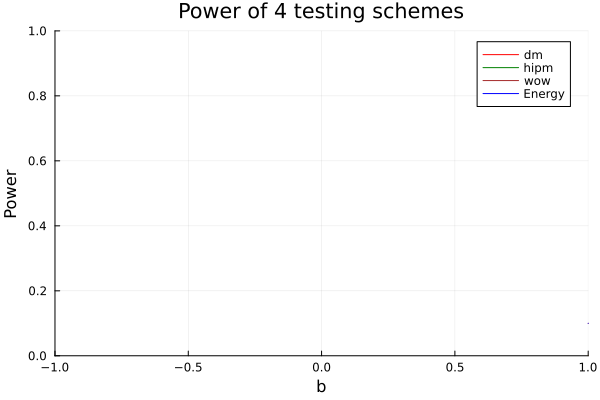

In [ ]:
b = collect(1.0:1:6.0)
n_top, n_bottom = 150, 100
n_boostrap = 50
S = 50
θ = 0.15

power_function = power_counter_example(b, n_top, n_bottom, n_boostrap, S, θ) # powers per δ for each tessting scheme
plot_power = plot(title = "Power of 4 testing schemes", xlabel = "b", ylabel = "Power", ylims = (0.0, 1.0))
plot!(plot_power, b, power_function[:,1], label = "dm", color = "red")
plot!(plot_power, b , power_function[:,2], label = "hipm", color = "green")
plot!(plot_power, b , power_function[:,3], label = "wow", color = "brown")
plot!(plot_power, b, power_function[:,4], label = "Energy", color = "blue")


In [19]:
b

10-element Vector{Float64}:
  1.0
  2.0
  3.0
  4.0
  5.0
  6.0
  7.0
  8.0
  9.0
 10.0

In [17]:
power_function

10×4 Matrix{Float64}:
 0.0  0.0  0.1  0.1
 0.0  0.2  0.2  0.1
 0.0  0.0  0.1  0.1
 0.0  0.1  0.2  0.0
 0.1  0.0  0.0  0.0
 0.1  0.5  0.5  0.3
 0.0  0.1  0.1  0.1
 0.0  0.0  0.0  0.0
 0.2  0.2  0.2  0.3
 0.0  0.2  0.2  0.0

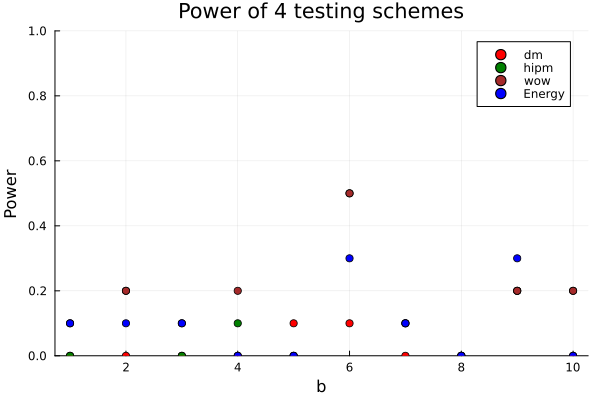

In [21]:
plot_power = plot(title = "Power of 4 testing schemes", xlabel = "b", ylabel = "Power", ylims = (0.0, 1.0))
scatter!(plot_power, b, power_function[:,1], label = "dm", color = "red")
scatter!(plot_power, b , power_function[:,2], label = "hipm", color = "green")
scatter!(plot_power, b , power_function[:,3], label = "wow", color = "brown")
scatter!(plot_power, b, power_function[:,4], label = "Energy", color = "blue")